In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi


# setting plt to inline
%matplotlib inline

# updating cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [3]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [4]:
q = "PRAGMA table_info('imdb_title_principals')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'tconst', 'TEXT', 0, None, 0),
 (2, 'ordering', 'INTEGER', 0, None, 0),
 (3, 'nconst', 'TEXT', 0, None, 0),
 (4, 'category', 'TEXT', 0, None, 0),
 (5, 'job', 'TEXT', 0, None, 0),
 (6, 'characters', 'TEXT', 0, None, 0)]

In [5]:
q = "PRAGMA table_info('imdb_name_basics')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 0),
 (1, 'nconst', 'TEXT', 0, None, 0),
 (2, 'primary_name', 'TEXT', 0, None, 0),
 (3, 'birth_year', 'REAL', 0, None, 0),
 (4, 'death_year', 'REAL', 0, None, 0),
 (5, 'primary_profession', 'TEXT', 0, None, 0),
 (6, 'known_for_titles', 'TEXT', 0, None, 0)]

In [6]:
q = "PRAGMA table_info('imdb_title_basics')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'tconst', 'TEXT', 0, None, 0),
 (2, 'primary_title', 'TEXT', 0, None, 0),
 (3, 'original_title', 'TEXT', 0, None, 0),
 (4, 'start_year', 'INTEGER', 0, None, 0),
 (5, 'runtime_minutes', 'REAL', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0)]

In [7]:
# getting column names
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [8]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
df = pd.DataFrame(fetcha(q))
df.columns = [i[0] for i in cur.description]
df.head(1)     

,idx,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,idx,tconst,ordering,...,start_year,runtime_minutes,genres,idx,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",466550,tt2398241,9,...,2017,90.0,"Adventure,Animation,Comedy",904,5,"Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [9]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [10]:
# dropping extraneous columns
df = df.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
df = df.rename(columns = {'movie':'title', 'release_date':'date'})
df.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy","Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [11]:
# checking numbers of NaNs
df.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [12]:
#cleaning numerical strings and converting to floats
df['worldwide_gross'] = df['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['domestic_gross'] = df['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['production_budget'] = df['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [13]:
# change date string to datetime object 
df.date = pd.to_datetime(df.date)
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)

In [14]:
df['international_gross'] = df['worldwide_gross'].sub(df['domestic_gross'])
df.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,international_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,152558304.0


In [15]:
df.head()

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,international_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,152558304.0
1,nm0063618,Jeff Beal,tt1147681,composer,"Drama,Mystery",2012-12-31,After,650000.0,0.0,0.0,2012,12,0.0
2,nm0070822,Terry Benedict,tt2119532,producer,"Biography,Drama,History",2016-11-04,Hacksaw Ridge,40000000.0,67209615.0,168904682.0,2016,11,101695067.0
3,nm0083851,Sam Bisbee,tt1990314,producer,"Comedy,Crime,Drama",2012-08-17,Robot & Frank,2500000.0,3317468.0,4934356.0,2012,8,1616888.0
4,nm0083851,Sam Bisbee,tt3813310,producer,"Crime,Thriller",2015-08-07,Cop Car,5000000.0,134552.0,143658.0,2015,8,9106.0


In [16]:
# defing function to adjust for inflation because the year/
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [17]:
#adding adjusted budget and gross profit columns
df['adj_prod_budg'] = df.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
df['adj_dom_gross'] = df.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
df['adj_ww_gross'] = df.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
df['adj_i_gross'] = df.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

df.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,year,month,international_gross,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,2017,4,152558304.0,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08


In [18]:
#adding net profit columns
df['adj_dom_net'] = df['adj_dom_gross'].sub(df['adj_prod_budg'])
df['adj_ww_net'] = df['adj_ww_gross'].sub(df['adj_prod_budg'])
df['adj_i_net'] = df['adj_i_gross'].sub(df['adj_prod_budg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   nconst               32406 non-null  object        
 1   primary_name         32406 non-null  object        
 2   tconst               32406 non-null  object        
 3   category             32406 non-null  object        
 4   genres               32146 non-null  object        
 5   date                 32406 non-null  datetime64[ns]
 6   title                32406 non-null  object        
 7   production_budget    32406 non-null  float64       
 8   domestic_gross       32406 non-null  float64       
 9   worldwide_gross      32406 non-null  float64       
 10  year                 32406 non-null  int64         
 11  month                32406 non-null  int64         
 12  international_gross  32406 non-null  float64       
 13  adj_prod_budg        32406 non-

In [19]:
#adding return on investment columns and checking results
df['adj_dom_roi'] = df['adj_dom_net'].divide(df['adj_prod_budg'])
df['adj_ww_roi'] = df['adj_ww_net'].divide(df['adj_prod_budg'])
df['adj_i_roi'] = df['adj_i_net'].divide(df['adj_prod_budg'])
df.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


In [20]:
title_gross = df[['title', 'adj_ww_gross', 'date']]
unique_titles = title_gross.drop_duplicates(subset = ['title'])
top20_grossing_films = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)
top20_grossing_films

,title,adj_ww_gross,date
6985,Bambi,4.203440e+09,1942-08-13
4866,Titanic,3.517408e+09,1997-12-19
16889,Avatar,3.308483e+09,2009-12-18
2320,Snow White and the Seven Dwarfs,3.283159e+09,1937-12-21
485,Avengers: Infinity War,2.085246e+09,2018-04-27
258,Jurassic World,1.778528e+09,2015-06-12
575,The Lion King,1.701301e+09,1994-06-15
1020,The Avengers,1.690249e+09,2012-05-04
447,Furious 7,1.638161e+09,2015-04-03
12913,Fantasia,1.521524e+09,1940-11-13


In [21]:
title_net = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net' ,'date']]
unique_titles = title_net.groupby('title').first().reset_index()
top20_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)
top20_net_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,date
195,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942-08-13
1518,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937-12-21
2109,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997-12-19
176,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009-12-18
178,Avengers: Infinity War,3.054359e+08,2.085246e+09,1.779810e+09,2018-04-27
1889,The Lion King,1.367989e+08,1.701301e+09,1.564502e+09,1994-06-15
932,Jurassic World,2.319085e+08,1.778528e+09,1.546619e+09,2015-06-12
600,Fantasia,4.163557e+07,1.521524e+09,1.479889e+09,1940-11-13
1651,The Avengers,2.505415e+08,1.690249e+09,1.439707e+09,2012-05-04
674,Furious 7,2.049424e+08,1.638161e+09,1.433219e+09,2015-04-03


In [22]:
title_roi = df[['title','adj_prod_budg',  'adj_ww_net', 'adj_ww_roi', 'date']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top20_roi_films

,title,adj_prod_budg,adj_ww_net,adj_ww_roi,date
1781,The Gallows,1.078644e+05,4.482465e+07,415.564740,2015-07-10
195,Bambi,1.345728e+07,4.189983e+09,311.354312,1942-08-13
1398,Rocky,4.493093e+06,1.006453e+09,224.000000,1976-11-21
1518,Snow White and the Seven Dwarfs,2.641789e+07,3.256741e+09,123.277880,1937-12-21
1732,The Devil Inside,1.113518e+06,1.121975e+08,100.759490,2012-01-06
724,Graduation Day,7.031271e+05,6.649895e+07,94.576000,1981-05-01
875,Insidious,1.704842e+06,1.118046e+08,65.580591,2011-04-01
2167,Unfriended,1.078644e+06,6.834742e+07,63.364198,2015-04-17
231,Benji,2.592870e+06,1.610668e+08,62.119120,1974-11-15
1247,Paranormal Activity 2,3.517312e+06,2.046044e+08,58.170677,2010-10-20


##  Top Creative Talent

In [23]:
df[df['tconst'] == 'tt0120338']

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi


In [24]:
df.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

## Top 20 Actors By Adjusted Gross

In [25]:
df = df[df.title != 'Titanic']

In [26]:
actor_df = df[df['category'].str.contains('actor')]

In [27]:
top20_grossing_actors = actor_df.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_actors = pd.DataFrame(top20_grossing_actors)
top20_actors

,adj_ww_gross
primary_name,
Robert Downey Jr.,1.049882e+10
Dwayne Johnson,8.735245e+09
Chris Evans,7.979593e+09
Chris Hemsworth,6.594242e+09
Mark Ruffalo,5.775902e+09
Johnny Depp,5.692888e+09
Chris Pratt,5.329209e+09
Vin Diesel,5.079759e+09
Jason Statham,4.459741e+09


In [28]:
def title_checker(DF, name):
    return pd.DataFrame(DF[DF['primary_name'] == name][['primary_name', 'nconst', 'title', 'tconst','year']])

In [29]:
names = list(top20_actors.index)
for name in names:
    print(title_checker(actor_df, name))

            primary_name     nconst                               title  \
10572  Robert Downey Jr.  nm0000375                        The Avengers   
10573  Robert Downey Jr.  nm0000375                        The Avengers   
10574  Robert Downey Jr.  nm0000375                          Iron Man 2   
10575  Robert Downey Jr.  nm0000375                            Due Date   
10576  Robert Downey Jr.  nm0000375                          Iron Man 3   
10577  Robert Downey Jr.  nm0000375  Sherlock Holmes: A Game of Shadows   
10578  Robert Downey Jr.  nm0000375                           The Judge   
10579  Robert Downey Jr.  nm0000375              Spider-Man: Homecoming   
10580  Robert Downey Jr.  nm0000375             Avengers: Age of Ultron   
10581  Robert Downey Jr.  nm0000375          Captain America: Civil War   
10582  Robert Downey Jr.  nm0000375              Avengers: Infinity War   

          tconst  year  
10572  tt0848228  2012  
10573  tt0848228  1998  
10574  tt1228705  2010  

In [30]:
drop_list = [10573, 11641, 11642, 11642, 9520 ,6042, 9006, 16423, 2345, 6219, 6209, 9045, 9754, 2674]

In [31]:
cleaned_actors = actor_df.drop(drop_list)

In [32]:
top20_2_grossing_actors = cleaned_actors.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_2_actors = pd.DataFrame(top20_2_grossing_actors)
top20_2_actors

,adj_ww_gross
primary_name,
Robert Downey Jr.,1.042262e+10
Dwayne Johnson,8.335910e+09
Chris Evans,7.903390e+09
Chris Hemsworth,6.580304e+09
Mark Ruffalo,5.775902e+09
Johnny Depp,5.692888e+09
Chris Pratt,5.329209e+09
Vin Diesel,5.079759e+09
Jason Statham,4.459741e+09


In [33]:
names2 = list(top20_2_actors.index)
for name in names2:
    print(title_checker(cleaned_actors, name))

            primary_name     nconst                               title  \
10572  Robert Downey Jr.  nm0000375                        The Avengers   
10574  Robert Downey Jr.  nm0000375                          Iron Man 2   
10575  Robert Downey Jr.  nm0000375                            Due Date   
10576  Robert Downey Jr.  nm0000375                          Iron Man 3   
10577  Robert Downey Jr.  nm0000375  Sherlock Holmes: A Game of Shadows   
10578  Robert Downey Jr.  nm0000375                           The Judge   
10579  Robert Downey Jr.  nm0000375              Spider-Man: Homecoming   
10580  Robert Downey Jr.  nm0000375             Avengers: Age of Ultron   
10581  Robert Downey Jr.  nm0000375          Captain America: Civil War   
10582  Robert Downey Jr.  nm0000375              Avengers: Infinity War   

          tconst  year  
10572  tt0848228  2012  
10574  tt1228705  2010  
10575  tt1231583  2010  
10576  tt1300854  2013  
10577  tt1515091  2011  
10578  tt1872194  2014  

In [34]:
drop_list2 =[12848]

In [35]:
cleaned_actors2 = cleaned_actors.drop(drop_list2)

In [36]:
top20_3_grossing_actors = cleaned_actors2.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_3_actors = pd.DataFrame(top20_3_grossing_actors)
top20_3_actors

,adj_ww_gross
primary_name,
Robert Downey Jr.,1.042262e+10
Dwayne Johnson,8.335910e+09
Chris Evans,7.903390e+09
Chris Hemsworth,6.580304e+09
Mark Ruffalo,5.775902e+09
Johnny Depp,5.692888e+09
Chris Pratt,5.329209e+09
Vin Diesel,5.079759e+09
Jason Statham,4.459741e+09


In [193]:
names3 = list(top20_3_actors.index)
for name in names3:
    print(title_checker(cleaned_actors2, name))

            primary_name     nconst                               title  \
10572  Robert Downey Jr.  nm0000375                        The Avengers   
10574  Robert Downey Jr.  nm0000375                          Iron Man 2   
10575  Robert Downey Jr.  nm0000375                            Due Date   
10576  Robert Downey Jr.  nm0000375                          Iron Man 3   
10577  Robert Downey Jr.  nm0000375  Sherlock Holmes: A Game of Shadows   
10578  Robert Downey Jr.  nm0000375                           The Judge   
10579  Robert Downey Jr.  nm0000375              Spider-Man: Homecoming   
10580  Robert Downey Jr.  nm0000375             Avengers: Age of Ultron   
10581  Robert Downey Jr.  nm0000375          Captain America: Civil War   
10582  Robert Downey Jr.  nm0000375              Avengers: Infinity War   

          tconst  year  
10572  tt0848228  2012  
10574  tt1228705  2010  
10575  tt1231583  2010  
10576  tt1300854  2013  
10577  tt1515091  2011  
10578  tt1872194  2014  

In [37]:
drop_list3 = [10549]

In [38]:
cleaned_actors3 = cleaned_actors2.drop(drop_list3)

In [39]:
top20_4_grossing_actors = cleaned_actors3.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_4_actors = pd.DataFrame(top20_4_grossing_actors)
top20_4_actors

,adj_ww_gross
primary_name,
Robert Downey Jr.,1.042262e+10
Dwayne Johnson,8.335910e+09
Chris Evans,7.903390e+09
Chris Hemsworth,6.580304e+09
Mark Ruffalo,5.775902e+09
Johnny Depp,5.692888e+09
Chris Pratt,5.329209e+09
Vin Diesel,5.079759e+09
Jason Statham,4.459741e+09


In [40]:
names4 = list(top20_4_actors.index)
for name in names4:
    print(title_checker(cleaned_actors3, name))

            primary_name     nconst                               title  \
10572  Robert Downey Jr.  nm0000375                        The Avengers   
10574  Robert Downey Jr.  nm0000375                          Iron Man 2   
10575  Robert Downey Jr.  nm0000375                            Due Date   
10576  Robert Downey Jr.  nm0000375                          Iron Man 3   
10577  Robert Downey Jr.  nm0000375  Sherlock Holmes: A Game of Shadows   
10578  Robert Downey Jr.  nm0000375                           The Judge   
10579  Robert Downey Jr.  nm0000375              Spider-Man: Homecoming   
10580  Robert Downey Jr.  nm0000375             Avengers: Age of Ultron   
10581  Robert Downey Jr.  nm0000375          Captain America: Civil War   
10582  Robert Downey Jr.  nm0000375              Avengers: Infinity War   

          tconst  year  
10572  tt0848228  2012  
10574  tt1228705  2010  
10575  tt1231583  2010  
10576  tt1300854  2013  
10577  tt1515091  2011  
10578  tt1872194  2014  

In [41]:
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)
count_m

,title
primary_name,
50 Cent,2
A. Önörjargal,1
A.J. Buckley,1
A.J. DeLucia,1
A.J. Merlin,1
...,...
Ângelo Paes Leme,1
Émile Bertherat,1
Ólafur Darri Ólafsson,1


In [42]:
joined_m = top20_4_actors.join(count_m)
joined_m.head()

,adj_ww_gross,title
primary_name,,
Robert Downey Jr.,1.042262e+10,11
Dwayne Johnson,8.335910e+09,19
Chris Evans,7.903390e+09,13
Chris Hemsworth,6.580304e+09,15
Mark Ruffalo,5.775902e+09,10


In [43]:
joined_m['mean_gross'] = joined_m.adj_ww_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [44]:
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title', ascending=False).head(20)
top20_cuml_gross_actors

,Actor,Cumulative Gross,Number of Titles,Mean Gross per Title
0,Robert Downey Jr.,1.042262e+10,11,9.475107e+08
1,Dwayne Johnson,8.335910e+09,19,4.387321e+08
2,Chris Evans,7.903390e+09,13,6.079531e+08
3,Chris Hemsworth,6.580304e+09,15,4.386869e+08
4,Mark Ruffalo,5.775902e+09,10,5.775902e+08
5,Johnny Depp,5.692888e+09,16,3.558055e+08
6,Chris Pratt,5.329209e+09,10,5.329209e+08
7,Vin Diesel,5.079759e+09,7,7.256798e+08
8,Jason Statham,4.459741e+09,13,3.430570e+08
9,Samuel L. Jackson,4.234895e+09,12,3.529079e+08


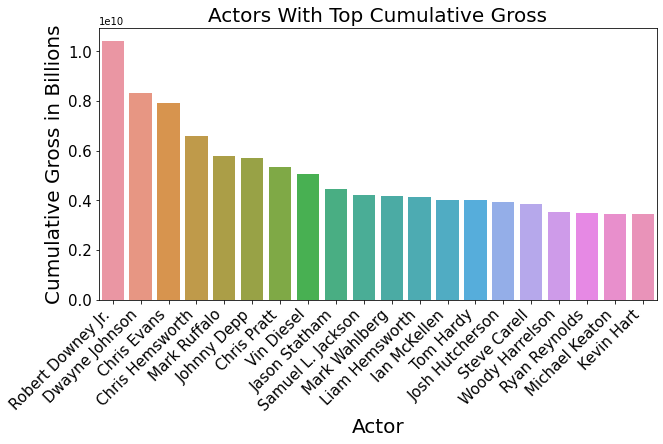

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actor", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Actors With Top Cumulative Gross", fontsize=20)
plt.show()

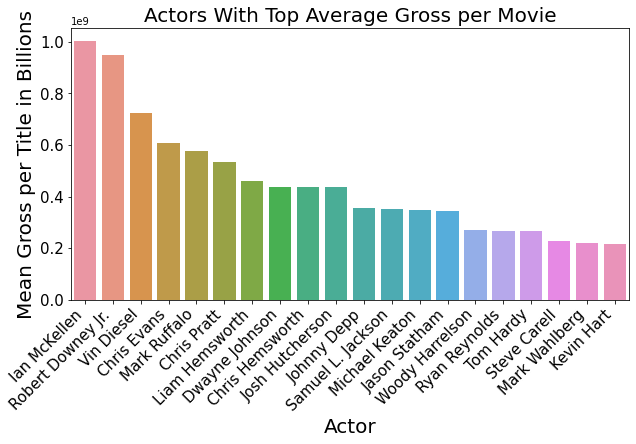

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actor", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actors With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Top 20 Actresses By Adjusted Gross

In [50]:
actress_df = df[df['category'].str.contains('actress')]

In [51]:
top20_grossing_actresses = actress_df.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_actresses = pd.DataFrame(top20_grossing_actresses)
top20_actresses

,adj_ww_gross
primary_name,
Cate Blanchett,7.329475e+09
Jennifer Lawrence,5.561662e+09
Scarlett Johansson,5.386301e+09
Helena Bonham Carter,5.176187e+09
Anne Hathaway,5.110396e+09
Rita Simons,4.820882e+09
Kristen Wiig,4.588155e+09
Bryce Dallas Howard,3.633204e+09
Lily James,3.547828e+09


In [52]:
names = list(top20_actresses.index)

In [53]:
def title_checker(DF, name):
    return pd.DataFrame(DF[DF['primary_name'] == name][['primary_name', 'nconst', 'title', 'tconst','year']])

In [54]:
names = list(top20_actresses.index)
for name in names:
    print(title_checker(actress_df, name))

        primary_name     nconst                                       title  \
7461  Cate Blanchett  nm0000949                                  Robin Hood   
7462  Cate Blanchett  nm0000949                                  Robin Hood   
7463  Cate Blanchett  nm0000949                                       Hanna   
7464  Cate Blanchett  nm0000949                  How to Train Your Dragon 2   
7465  Cate Blanchett  nm0000949                                  Cinderella   
7466  Cate Blanchett  nm0000949                                  Cinderella   
7467  Cate Blanchett  nm0000949                           The Monuments Men   
7468  Cate Blanchett  nm0000949   The Hobbit: The Battle of the Five Armies   
7469  Cate Blanchett  nm0000949                                Blue Jasmine   
7470  Cate Blanchett  nm0000949  How to Train Your Dragon: The Hidden World   
7471  Cate Blanchett  nm0000949                                       Carol   
7472  Cate Blanchett  nm0000949                     

In [55]:
drop_list = [7461, 7466, 2196, 4893, 4896, 2423, 2431,\
             15716, 15653, 16810, 23679, 11183, 28285, 17618,\
             23903, 19032, 21676, 20100, 28394, 30195]

In [56]:
cleaned_actresses = actress_df.drop(drop_list)

In [57]:
top20_2_grossing_actresses = cleaned_actresses.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_2_actresses = pd.DataFrame(top20_2_grossing_actresses)
top20_2_actresses

,adj_ww_gross
primary_name,
Jennifer Lawrence,5.561662e+09
Scarlett Johansson,5.310098e+09
Anne Hathaway,5.057616e+09
Cate Blanchett,4.446968e+09
Kristen Wiig,3.861753e+09
Bryce Dallas Howard,3.633204e+09
Emma Stone,3.420498e+09
Raai Laxmi,3.372814e+09
Ebony Lanet,3.372814e+09


In [58]:
names2 = list(top20_2_actresses.index)
for name in names2:
    print(title_checker(cleaned_actresses, name))

            primary_name     nconst                                  title  \
17681  Jennifer Lawrence  nm2225369                Silver Linings Playbook   
17682  Jennifer Lawrence  nm2225369                     X-Men: First Class   
17683  Jennifer Lawrence  nm2225369                             Passengers   
17684  Jennifer Lawrence  nm2225369                       The Hunger Games   
17685  Jennifer Lawrence  nm2225369                          Winter's Bone   
17686  Jennifer Lawrence  nm2225369         House at the End of the Street   
17687  Jennifer Lawrence  nm2225369                             Like Crazy   
17688  Jennifer Lawrence  nm2225369                        American Hustle   
17689  Jennifer Lawrence  nm2225369        The Hunger Games: Catching Fire   
17690  Jennifer Lawrence  nm2225369  The Hunger Games: Mockingjay - Part 1   
17691  Jennifer Lawrence  nm2225369  The Hunger Games: Mockingjay - Part 2   
17692  Jennifer Lawrence  nm2225369                             

In [59]:
drop_list2 = [13082, 30138, 29111, 6719, 27509, 17879, 19965, 22193, 23039, 19181, 25135, 31683, 10173]

In [60]:
cleaned_actresses2 = cleaned_actresses.drop(drop_list2)

In [61]:
top20_3_grossing_actresses = cleaned_actresses2.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_3_actresses = pd.DataFrame(top20_3_grossing_actresses)
top20_3_actresses

,adj_ww_gross
primary_name,
Jennifer Lawrence,5.561662e+09
Scarlett Johansson,5.310098e+09
Anne Hathaway,5.057616e+09
Cate Blanchett,4.446968e+09
Kristen Wiig,3.861753e+09
Bryce Dallas Howard,3.633204e+09
Emma Stone,3.420498e+09
Madison Vollmer,2.891351e+09
Amy Adams,2.837346e+09


In [62]:
names3 = list(top20_3_actresses.index)
for name in names3:
    print(title_checker(cleaned_actresses2, name))

            primary_name     nconst                                  title  \
17681  Jennifer Lawrence  nm2225369                Silver Linings Playbook   
17682  Jennifer Lawrence  nm2225369                     X-Men: First Class   
17683  Jennifer Lawrence  nm2225369                             Passengers   
17684  Jennifer Lawrence  nm2225369                       The Hunger Games   
17685  Jennifer Lawrence  nm2225369                          Winter's Bone   
17686  Jennifer Lawrence  nm2225369         House at the End of the Street   
17687  Jennifer Lawrence  nm2225369                             Like Crazy   
17688  Jennifer Lawrence  nm2225369                        American Hustle   
17689  Jennifer Lawrence  nm2225369        The Hunger Games: Catching Fire   
17690  Jennifer Lawrence  nm2225369  The Hunger Games: Mockingjay - Part 1   
17691  Jennifer Lawrence  nm2225369  The Hunger Games: Mockingjay - Part 2   
17692  Jennifer Lawrence  nm2225369                             

In [63]:
drop_list3 = [2316, 2317, 5733, 5735, 920, 4003]

In [64]:
cleaned_actresses3 = cleaned_actresses2.drop(drop_list3)

In [65]:
top20_3_grossing_actresses = cleaned_actresses3.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(20) 
top20_3_actresses = pd.DataFrame(top20_3_grossing_actresses)
top20_3_actresses

,adj_ww_gross
primary_name,
Jennifer Lawrence,5.561662e+09
Scarlett Johansson,5.310098e+09
Anne Hathaway,5.057616e+09
Cate Blanchett,4.446968e+09
Kristen Wiig,3.861753e+09
Bryce Dallas Howard,3.633204e+09
Emma Stone,3.420498e+09
Amy Adams,2.837346e+09
Angelina Jolie,2.797727e+09


In [66]:
names4 = list(top20_3_actresses.index)
for name in names4:
    print(title_checker(cleaned_actresses3, name))

            primary_name     nconst                                  title  \
17681  Jennifer Lawrence  nm2225369                Silver Linings Playbook   
17682  Jennifer Lawrence  nm2225369                     X-Men: First Class   
17683  Jennifer Lawrence  nm2225369                             Passengers   
17684  Jennifer Lawrence  nm2225369                       The Hunger Games   
17685  Jennifer Lawrence  nm2225369                          Winter's Bone   
17686  Jennifer Lawrence  nm2225369         House at the End of the Street   
17687  Jennifer Lawrence  nm2225369                             Like Crazy   
17688  Jennifer Lawrence  nm2225369                        American Hustle   
17689  Jennifer Lawrence  nm2225369        The Hunger Games: Catching Fire   
17690  Jennifer Lawrence  nm2225369  The Hunger Games: Mockingjay - Part 1   
17691  Jennifer Lawrence  nm2225369  The Hunger Games: Mockingjay - Part 2   
17692  Jennifer Lawrence  nm2225369                             

In [67]:
movie_count_f = actress_df.groupby(['primary_name']).title.count()
count_f = pd.DataFrame(movie_count_f)
count_f

,title
primary_name,
AJ Michalka,2
Aamu Milonoff,1
Aanchal Sabharwal,1
Abbie Cornish,5
Abby Craden,1
...,...
Zsófia Szamosi,1
Zulay Henao,1
Zuzana Mauréry,1


In [69]:
joined_f = top20_3_actresses.join(count_f)
joined_f.head()

,adj_ww_gross,title
primary_name,,
Jennifer Lawrence,5.561662e+09,15
Scarlett Johansson,5.310098e+09,12
Anne Hathaway,5.057616e+09,13
Cate Blanchett,4.446968e+09,12
Kristen Wiig,3.861753e+09,12


In [70]:
joined_f['mean_gross'] = joined_f.adj_ww_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [71]:
top20_cuml_gross_actresses =  joined_f.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values(by='Mean Gross per Title', ascending=False).head(20)
top20_cuml_gross_actresses

,Actress,Cumulative Gross,Number of Titles,Mean Gross per Title
0,Jennifer Lawrence,5.561662e+09,15,3.707774e+08
1,Scarlett Johansson,5.310098e+09,12,4.425081e+08
2,Anne Hathaway,5.057616e+09,13,3.890474e+08
3,Cate Blanchett,4.446968e+09,12,3.705807e+08
4,Kristen Wiig,3.861753e+09,12,3.218127e+08
5,Bryce Dallas Howard,3.633204e+09,6,6.055340e+08
6,Emma Stone,3.420498e+09,12,2.850415e+08
7,Amy Adams,2.837346e+09,14,2.026676e+08
8,Angelina Jolie,2.797727e+09,6,4.662878e+08
9,Emily Blunt,2.536024e+09,14,1.811445e+08


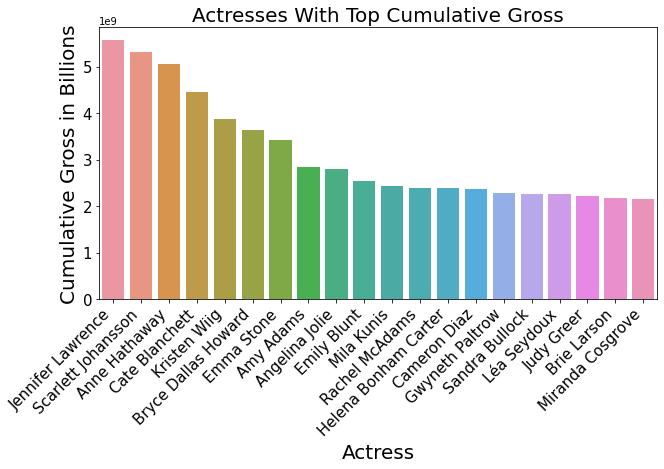

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Cumulative Gross', data=top20_cuml_gross_actresses)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actress", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Cumulative Gross", fontsize=20)
plt.show()

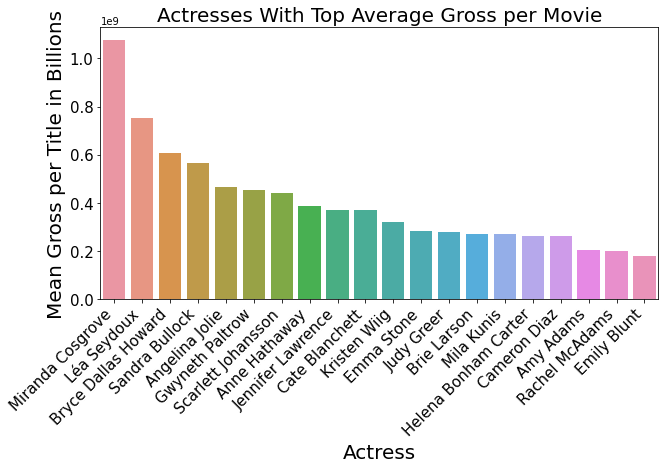

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Mean Gross per Title', data=top20_mean_gross_actresses)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actress", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Top Directors by Gross

In [ ]:
director_df = df[df['category'].str.contains('director')]

In [ ]:
top20_grossing_directors = director_df.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(21)
top20_directors = pd.DataFrame(top20_grossing_directors)
top20_directors

In [ ]:
movie_count_d = director_df.groupby(['primary_name']).title.count()
count_d = pd.DataFrame(movie_count_d)
count_d

In [ ]:
joined_d = top20_directors.join(count_d)
joined_d.head()

In [ ]:
joined_d['mean_gross'] = joined_d.adj_ww_gross/joined_d.title
joined_d = joined_d.reset_index()
joined_d = joined_d.rename(columns={'primary_name': 'Director',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [ ]:
top20_cuml_gross_directors =  joined_d.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_directors = joined_d.sort_values(by='Mean Gross per Title', ascending=False).head(20)
top20_cuml_gross_directors

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Cumulative Gross', data=top20_cuml_gross_directors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Director", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Directors With Top Cumulative Gross", fontsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Mean Gross per Title', data=top20_mean_gross_directors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Director", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Directors With Top Average Gross per Movie", fontsize=20) 
plt.show() 

In [ ]:
df[df['primary_name'] == 'Sébastien Lifshitz']

In [ ]:
producer_df = df[df['category'].str.contains('producer')]
producer_df.head()

In [ ]:
top_producers_films = producer_df.sort_values(by=['worldwide_gross'], ascending=False).head(20)
top_producers_films[['primary_name', 'movie', 'worldwide_gross', 'release_date']].head()

In [ ]:
top20_grossing_producers = producer_df.groupby(['primary_name']).worldwide_gross.sum().sort_values(ascending=False).head(20)
top20_grossing_producers

In [ ]:
writer_df = df[df['category'].str.contains('writer')]
writer_df.head()

In [ ]:
top_writers_films = writer_df.sort_values(by=['worldwide_gross'], ascending=False).head(20)
top_writers_films[['primary_name', 'movie', 'worldwide_gross', 'release_date']].head()

In [ ]:
top20_grossing_writers = writer_df.groupby(['primary_name']).worldwide_gross.sum().sort_values(ascending=False).head(20)
top20_grossing_writers